# Load in EEG Dataset

### Dataset and Splitter Class

Classes to allow us to work with the pth file containing the EEG and labels.

In [1]:
class EEGDataset:
    """
    The EEG dataset is a class that allows us to load in the pth file and extract the EEG data,
    the image associated with the EEG and the label. It also has information on the mean and 
    std of the EEG data so that the data can be standardised.
    """

    def __init__(self, eeg_data_file):
        """
        Extracts information out of the pth file.
        """
        loaded = eeg_data_file
        self.data = loaded["dataset"]
        self.labels = loaded["labels"]
        self.images = loaded["images"]
        self.means = loaded["means"]
        self.stddevs = loaded["stddevs"]
        self.size = len(self.data)


    def __len__(self):
        return self.size


    def __getitem__(self, i):
        """
        Returns an EEG time series that has been standardised and has the ends clipped.
        """
        eeg = ((self.data[i]["eeg"].float() - self.means) / self.stddevs)  # .t() # CxT
        eeg = eeg.t()
        eeg = eeg[20:450, :]
        label = self.data[i]["label"]
        return eeg, label



class Splitter:
    """
    Class used in the dataset argument in the PyTorch DataLoader object. This allows for the
    EEG data and label to be given.
    """

    def __init__(self, dataset, split_path, split_num=0, split_name="train"):
        """
        Load in the pth file defining the splits and filter out data to avoid.
        """
        self.dataset = dataset
        loaded = split_path
        self.split_idx = loaded["splits"][split_num][split_name]
        self.split_idx = [i for i in self.split_idx if 450 <= self.dataset.data[i]["eeg"].size(1) <= 600]
        self.size = len(self.split_idx)

    def __len__(self):
        return self.size


    def __getitem__(self, i):
        """
        Return the EEG data and the associated label (image class).
        """
        eeg, label = self.dataset[self.split_idx[i]]
        return eeg, label

### Load in Dataset and Splitter

Create the loaders variable to be used later on in training to load in train/test/eval data.

In [2]:
import torch
from torch.utils.data import DataLoader

splits_by_image_file = torch.load('split_by_image.pth')
eeg_data_file = torch.load('eeg_dataset.pth')
dataset = EEGDataset(eeg_data_file)
mini_batch = 16

loaders = {
    split: DataLoader
    (
        dataset = Splitter
        (
            dataset=dataset,
            split_path=splits_by_image_file,
            split_num=0, 
            split_name=split
        ),
        batch_size=mini_batch, 
        drop_last=True, 
        shuffle=True
    ) 
    for split in ["train", "val", "test"]
}

# Train the RNN Encoder

Train the model to correctly classify what class of image was being observed by the participant.

### Encoder



In [3]:
import torch.nn as nn

class EEGClassifier(nn.Module):
    """
    The LSTM RRN PyTorch model used in this classification process. 
    """

    def __init__(self, input_size, lstm_size, lstm_layers, embedding_size, num_classes):
        """
        Defining the layers to be used in the RNN.
        """
        super().__init__()
        self.lstm = nn.LSTM(input_size, lstm_size, num_layers=lstm_layers, batch_first=True)
        self.embedding = nn.Linear(lstm_size, embedding_size)
        self.classifier = nn.Linear(embedding_size, num_classes)

    def forward(self, x):
        """
        The forward pass of the encoder. The LSTM takes the data and we take the final state (-1)
        of this. We then get the embedding of this which will later on be the embedding used in 
        the GAN conditioning, but for now is used by a linear layer (self.classifier) to classify
        the image class.
        
        param x: eeg time series.
        
        return: num_classes-length vector, the argmax of this is the image class (the label).
        """
        x = self.lstm(x)[0][:, -1, :]
        emb = F.relu(self.embedding(x))
        x = self.classifier(emb)
        return x

### Training Function

In [4]:
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt


def plot_loss(epochsToPlot, trLoss, vaLoss):
    """
    Function to plot the losses. 
    """
    print("Performance:")
    plt.plot(epochsToPlot, trLoss, label='Training Loss')
    plt.plot(epochsToPlot, vaLoss, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    

def train(epochs, printLossesAtEpoch, lstm_units, lstm_layers, embedding_size, num_classes, mini_batch):
    """
    Function to train the encoder. 
    
    This method instantiates the model and some empty arrays in which the losses will be appended to.
    It then goes through the test/train/val split, training the model on the training set. At the end
    of the epoch it saves the loss progress, prints the performance and saves the model.
    
    param epochs: the input to the activation
    param printLossesAtEpoch: the number of epochs before a the loss is plotted.
    param lstm_units: amount of lstm units per layer.
    param lstm_layers: amount of lstm layers.
    param embedding_size: embedding size we want the EEG to be embedded in.
    param num_classes: number of image classes.
    param mini_batch: the input to the activation
    """
    
    model = EEGClassifier(128, lstm_units, lstm_layers, embedding_size, num_classes)  
    optimizer = getattr(torch.optim, "Adam")(model.parameters(), lr=0.001)
    # Set up arrays to use to store performance
    trLoss = np.array([])
    vaLoss = np.array([])
    
    # Start training
    for epoch in range(1, epochs + 1):
        # Initialize loss/accuracy variables
        losses = {"train": 0, "val": 0, "test": 0}
        accuracies = {"train": 0, "val": 0, "test": 0}
        counts = {"train": 0, "val": 0, "test": 0}
        # Process each split
        for split in ("train", "val", "test"):
            # Set network mode
            if split == "train":
                model.train()
                torch.set_grad_enabled(True)
            else:
                model.eval()
                torch.set_grad_enabled(False)
            # Process all split batches
            for i, (input, target) in enumerate(loaders[split]):
                # Forward
                output = model(input)
                loss = F.cross_entropy(output, target)
                losses[split] += loss.item()
                # Compute accuracy
                _, pred = output.data.max(1)
                correct = pred.eq(target.data).sum().item()
                accuracy = correct / input.data.size(0)
                accuracies[split] += accuracy
                counts[split] += 1
                # Backward and optimize
                if split == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
      
        # print progress
        print("Epoch {0}: TrL={1:.4f}, TrA={2:.4f}, VL={3:.4f}, VA={4:.4f}, TeL={5:.4f}, TeA={6:.4f}".format(
            epoch,
            losses["train"] /counts["train"],
            accuracies["train"] /counts["train"],
            losses["val"] /counts["val"],
            accuracies["val"] /counts["val"],
            losses["test"] /counts["test"],
            accuracies["test"] /counts["test"]))
        
        
        # Now add the training loss, val loss and epoch to an np array - this is for plotting
        trLoss = np.append(trLoss, losses["train"] / counts["train"])
        vaLoss = np.append(vaLoss, losses["val"] / counts["val"])
        numEpochs = trLoss.shape[0]
        epochsToPlot = np.linspace(1, numEpochs, numEpochs)
    
        # plot
        if epoch % printLossesAtEpoch == 0:
            plot_loss(epochsToPlot, trLoss, vaLoss)

      
        # save the model 
        file_name = 'encoder_model.pth'
        torch.save(model.state_dict(), file_name)

### Training

Epoch 1: TrL=2.7600, TrA=0.1870, VL=1.9650, VA=0.3548, TeL=1.9655, TeA=0.3311
Epoch 2: TrL=1.7561, TrA=0.4117, VL=1.5824, VA=0.4496, TeL=1.5668, TeA=0.4637
Epoch 3: TrL=1.5191, TrA=0.5074, VL=1.3388, VA=0.5408, TeL=1.3451, TeA=0.5519
Epoch 4: TrL=1.0548, TrA=0.6395, VL=1.0593, VA=0.6331, TeL=1.0256, TeA=0.6547
Epoch 5: TrL=0.8238, TrA=0.7196, VL=0.8383, VA=0.7188, TeL=0.8077, TeA=0.7263
Epoch 6: TrL=0.6950, TrA=0.7643, VL=0.7221, VA=0.7571, TeL=0.7840, TeA=0.7369
Epoch 7: TrL=0.5529, TrA=0.8174, VL=0.6829, VA=0.7686, TeL=0.6806, TeA=0.7757
Epoch 8: TrL=0.4827, TrA=0.8415, VL=0.5839, VA=0.8009, TeL=0.6217, TeA=0.7984
Epoch 9: TrL=0.4387, TrA=0.8537, VL=0.6275, VA=0.8105, TeL=0.6289, TeA=0.8095
Epoch 10: TrL=0.3811, TrA=0.8736, VL=0.5476, VA=0.8306, TeL=0.5383, TeA=0.8271
Epoch 11: TrL=0.4231, TrA=0.8646, VL=0.5693, VA=0.8231, TeL=0.5815, TeA=0.8115
Epoch 12: TrL=0.3238, TrA=0.9005, VL=0.5016, VA=0.8402, TeL=0.5181, TeA=0.8337
Epoch 13: TrL=0.2907, TrA=0.9096, VL=0.4074, VA=0.8705, TeL=0

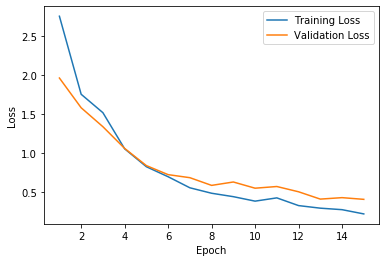

Epoch 16: TrL=0.2142, TrA=0.9318, VL=0.3477, VA=0.8871, TeL=0.3698, TeA=0.8876
Epoch 17: TrL=0.1854, TrA=0.9419, VL=0.4533, VA=0.8725, TeL=0.4259, TeA=0.8770
Epoch 18: TrL=0.2476, TrA=0.9269, VL=0.3686, VA=0.8851, TeL=0.3839, TeA=0.8901
Epoch 19: TrL=0.1907, TrA=0.9401, VL=0.4754, VA=0.8564, TeL=0.4521, TeA=0.8679
Epoch 20: TrL=0.2062, TrA=0.9357, VL=0.3445, VA=0.8947, TeL=0.3719, TeA=0.8891
Epoch 21: TrL=0.1788, TrA=0.9438, VL=0.5118, VA=0.8528, TeL=0.4698, TeA=0.8609
Epoch 22: TrL=0.1704, TrA=0.9457, VL=0.3626, VA=0.8861, TeL=0.3845, TeA=0.8881
Epoch 23: TrL=0.1673, TrA=0.9478, VL=0.3911, VA=0.8841, TeL=0.3847, TeA=0.8916
Epoch 24: TrL=0.1221, TrA=0.9649, VL=0.2713, VA=0.9214, TeL=0.3074, TeA=0.9128
Epoch 25: TrL=0.0913, TrA=0.9741, VL=0.2987, VA=0.9163, TeL=0.3205, TeA=0.9173
Epoch 26: TrL=0.1502, TrA=0.9535, VL=0.4317, VA=0.8720, TeL=0.4070, TeA=0.8821
Epoch 27: TrL=0.1357, TrA=0.9559, VL=0.3473, VA=0.9022, TeL=0.3757, TeA=0.9007
Epoch 28: TrL=0.1181, TrA=0.9643, VL=0.3169, VA=0.91

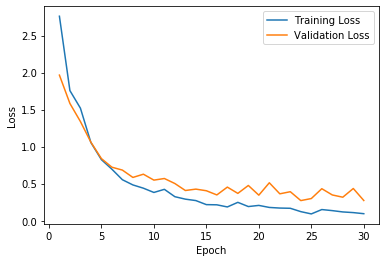

Epoch 31: TrL=0.1123, TrA=0.9647, VL=0.2568, VA=0.9259, TeL=0.2744, TeA=0.9163
Epoch 32: TrL=0.1124, TrA=0.9643, VL=0.5827, VA=0.8589, TeL=0.5038, TeA=0.8664
Epoch 33: TrL=0.1484, TrA=0.9547, VL=0.3725, VA=0.8947, TeL=0.4006, TeA=0.8906
Epoch 34: TrL=0.0947, TrA=0.9717, VL=0.3377, VA=0.9148, TeL=0.3217, TeA=0.9133
Epoch 35: TrL=0.0667, TrA=0.9813, VL=0.3089, VA=0.9199, TeL=0.2877, TeA=0.9299
Epoch 36: TrL=0.0657, TrA=0.9815, VL=0.2174, VA=0.9345, TeL=0.2367, TeA=0.9370
Epoch 37: TrL=0.0635, TrA=0.9821, VL=0.3576, VA=0.9047, TeL=0.3408, TeA=0.9073
Epoch 38: TrL=0.1268, TrA=0.9600, VL=0.3257, VA=0.9118, TeL=0.3064, TeA=0.9108
Epoch 39: TrL=0.0830, TrA=0.9770, VL=0.3280, VA=0.9244, TeL=0.2507, TeA=0.9294
Epoch 40: TrL=0.0692, TrA=0.9795, VL=0.2387, VA=0.9294, TeL=0.2422, TeA=0.9299
Epoch 41: TrL=0.0642, TrA=0.9801, VL=0.2687, VA=0.9340, TeL=0.2671, TeA=0.9330
Epoch 42: TrL=0.0900, TrA=0.9715, VL=0.2501, VA=0.9309, TeL=0.2781, TeA=0.9189
Epoch 43: TrL=0.0744, TrA=0.9779, VL=0.4073, VA=0.89

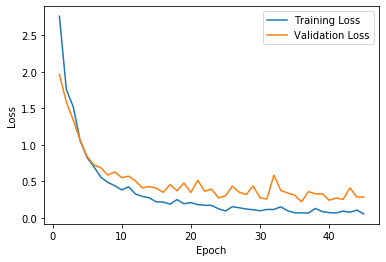

Epoch 46: TrL=0.0578, TrA=0.9823, VL=0.2511, VA=0.9304, TeL=0.2839, TeA=0.9294
Epoch 47: TrL=0.0504, TrA=0.9849, VL=0.1980, VA=0.9420, TeL=0.2209, TeA=0.9430
Epoch 48: TrL=0.1078, TrA=0.9721, VL=0.3204, VA=0.9057, TeL=0.3269, TeA=0.9128
Epoch 49: TrL=0.0849, TrA=0.9757, VL=0.2384, VA=0.9365, TeL=0.2705, TeA=0.9315
Epoch 50: TrL=0.0579, TrA=0.9828, VL=0.2764, VA=0.9320, TeL=0.2649, TeA=0.9294
Epoch 51: TrL=0.0784, TrA=0.9790, VL=0.2943, VA=0.9219, TeL=0.3229, TeA=0.9083
Epoch 52: TrL=0.0811, TrA=0.9764, VL=0.2436, VA=0.9335, TeL=0.2418, TeA=0.9415
Epoch 53: TrL=0.0379, TrA=0.9891, VL=0.1757, VA=0.9577, TeL=0.2019, TeA=0.9491
Epoch 54: TrL=0.0441, TrA=0.9865, VL=0.4531, VA=0.9027, TeL=0.3448, TeA=0.9158
Epoch 55: TrL=0.1013, TrA=0.9699, VL=0.2936, VA=0.9325, TeL=0.3003, TeA=0.9284
Epoch 56: TrL=0.0526, TrA=0.9854, VL=0.2416, VA=0.9435, TeL=0.2444, TeA=0.9400
Epoch 57: TrL=0.0575, TrA=0.9852, VL=0.2581, VA=0.9335, TeL=0.2491, TeA=0.9380
Epoch 58: TrL=0.0881, TrA=0.9737, VL=0.2307, VA=0.94

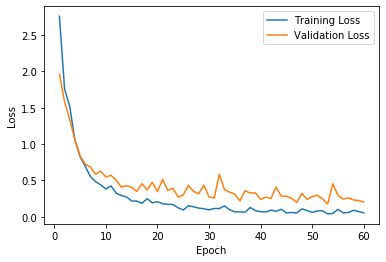

In [5]:
train(epochs=60, 
      printLossesAtEpoch=15, 
      lstm_units=128, 
      lstm_layers=1, 
      embedding_size=126, 
      num_classes=40, 
      mini_batch=mini_batch)

# Aquire the EEG Embeddings for Each Class

### Build the truncated classifier (the encoder)

In [44]:
class Encoder(nn.Module):
    """
    The truncated classifier. 
    
    This is the same model as before however in the forward method you can see
    the output is 'emb', which is the 126-length embeddings of the EEG.
    
    """

    def __init__(self, input_size, lstm_size, lstm_layers, embedding_size, num_classes):
        """
        Instantiate the layers on the PyTorch model.
        """
        super().__init__()
        self.lstm = nn.LSTM(input_size, lstm_size, num_layers=lstm_layers, batch_first=True)
        self.embedding = nn.Linear(lstm_size, embedding_size)
        self.classifier = nn.Linear(embedding_size, num_classes)

    def forward(self, x):
        """
        Forward pass of the model. Note that the output is the embeddings, rather
        than a classification.
        """
        batch_size = x.size(0)
        x = self.lstm(x)[0][:, -1, :]
        emb = F.relu(self.embedding(x))
        return emb

    
encoder = Encoder(
    input_size=128, 
    lstm_size=128, 
    lstm_layers=1, 
    embedding_size=126, 
    num_classes=40
) 

# Load the weights into the truncated version of the model
encoder.load_state_dict(torch.load('encoder_model.pth'))    
pass

### Extract Embeddings 

We calculate the average embedding for each class and save each of these in EEG_emb_average.

In [45]:
embedding_size=126
num_classes=40
num_images_per_class = 300
EEG_emb_average = np.zeros(shape=(num_classes,embedding_size))

for i in range(dataset.size):
    eeg_point, label = dataset.__getitem__(i)
    embedding = encoder(eeg_point.unsqueeze(0))
    embeddings_np = embedding.detach().numpy()
    EEG_emb_average[label] = np.add(EEG_emb_tot_np[label], embeddings_np/num_images_per_class)

### Plot Embeddings

Here we plot the embeddings for classes 'German Shepherd' and 'Banana'.

It is clear that these are not one-hot encodings. We theorise that these embeddings may contain more information about the image class than a one-hot encoding.

Text(0.5, 1.0, 'EEG Embedding for Banana')

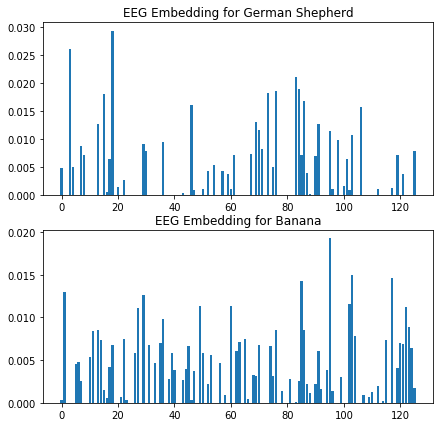

In [86]:
fig, axs = plt.subplots(2)
fig.set_size_inches(7, 7)
axs[0].bar(x, EEG_emb_average[12])
axs[0].set_title('EEG Embedding for German Shepherd')
axs[1].bar(x, EEG_emb_average[32])
axs[1].set_title('EEG Embedding for Banana')

### Save the embeddings as numpy files

We have the following labels for our image classes. We chose 20 total classes instead of 40 as we don't have the resources to train a GAN with a dataset twice the size.

| Image Class  |  Label | 
|---|---|
|Iron|2|
|Panda|8|
|Daisy|9|
|Lycaenid butterfly|11|
|German shepherd|12|
|Running shoe|13|
|Jack-o-lantern|14|
|Cellphone|15|
|Golf_ball|16|
|Broom|18|
|Missile|20|
|Convertible|24|
|Mitten|27|
|Electric_guitar|28|
|Piano|30|
|Banana|32|
|Bolete|33|
|Airliner|36|
|Radio_telescope|38|
|Egyptian_cat|39|

In [81]:
emb_dir = "EEG_embeddings/"

np.save(emb_dir + 'eeg_emb_iron',EEG_emb_average[2])
np.save(emb_dir + 'eeg_emb_panda',EEG_emb_average[8])
np.save(emb_dir + 'eeg_emb_daisy',EEG_emb_average[9])
np.save(emb_dir + 'eeg_emb_lycaenid_butterfly',EEG_emb_average[11])
np.save(emb_dir + 'eeg_emb_german_shepherd',EEG_emb_average[12])
np.save(emb_dir + 'eeg_emb_running_shoe',EEG_emb_average[13])
np.save(emb_dir + 'eeg_emb_jack-o-lantern',EEG_emb_average[14])
np.save(emb_dir + 'eeg_emb_cellphone',EEG_emb_average[15])
np.save(emb_dir + 'eeg_emb_golf_ball',EEG_emb_average[16])
np.save(emb_dir + 'eeg_emb_broom',EEG_emb_average[18])
np.save(emb_dir + 'eeg_emb_missile',EEG_emb_average[20])
np.save(emb_dir + 'eeg_emb_convertible',EEG_emb_average[24])
np.save(emb_dir + 'eeg_emb_mitten',EEG_emb_average[27])
np.save(emb_dir + 'eeg_emb_electric_guitar',EEG_emb_average[28])
np.save(emb_dir + 'eeg_emb_piano',EEG_emb_average[30])
np.save(emb_dir + 'eeg_emb_banana',EEG_emb_average[32])
np.save(emb_dir + 'eeg_emb_bolete',EEG_emb_average[33])
np.save(emb_dir + 'eeg_emb_airliner',EEG_emb_average[36])
np.save(emb_dir + 'eeg_emb_radio_telescope',EEG_emb_average[38])
np.save(emb_dir + 'eeg_emb_egyptian_cat',EEG_emb_average[39])